In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, SimpleRNN, Flatten, Input, GlobalMaxPool1D
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.metrics import mean_absolute_error
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# 1. RNN

## 1.1 Simple RNN

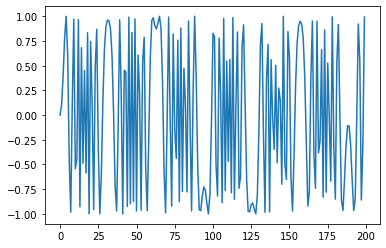

In [ ]:
# make the original data
# series = np.sin(0.1 * np.arange(200)) + np.random.randn(200) * 0.2
series = np.sin(0.1 * np.arange(200) ** 2)
plt.plot(series)

In [ ]:
# Data Pre-Process
T, D, X, Y = 10, 1, [], []

for t in range(len(series) - T):
    x = series[t : t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)

# the data should be N x T x D
X = np.array(X).reshape(-1, T, D)
Y = np.array(Y)
N = len(X)
print("X:", X.shape, "\tY:", Y.shape)

X: (190, 10, 1) 	Y: (190,)


In [ ]:
i = Input(shape=(T, D))
x = SimpleRNN(10, activation='tanh')(i)
# x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.05))

r = model.fit(X[: N // 2], Y[: N // 2], epochs=200, validation_data=(X[-N // 2 :], Y[-N // 2 :]))

Epoch 1/200
3/3 [==============================] - 1s 101ms/step - loss: 0.9202 - val_loss: 0.5152
Epoch 2/200
3/3 [==============================] - 0s 24ms/step - loss: 0.6427 - val_loss: 0.4931
Epoch 3/200
3/3 [==============================] - 0s 22ms/step - loss: 0.5228 - val_loss: 0.5697
Epoch 4/200
3/3 [==============================] - 0s 25ms/step - loss: 0.6001 - val_loss: 0.5570
Epoch 5/200
3/3 [==============================] - 0s 23ms/step - loss: 0.5617 - val_loss: 0.4873
Epoch 6/200
3/3 [==============================] - 0s 30ms/step - loss: 0.5012 - val_loss: 0.4673
Epoch 7/200
3/3 [==============================] - 0s 25ms/step - loss: 0.5359 - val_loss: 0.4715
Epoch 8/200
3/3 [==============================] - 0s 22ms/step - loss: 0.5332 - val_loss: 0.4583
Epoch 9/200
3/3 [==============================] - 0s 22ms/step - loss: 0.5222 - val_loss: 0.4828
Epoch 10/200
3/3 [==============================] - 0s 25ms/step - loss: 0.4717 - val_loss: 0.4811
Epoch 11/200
3/3 [

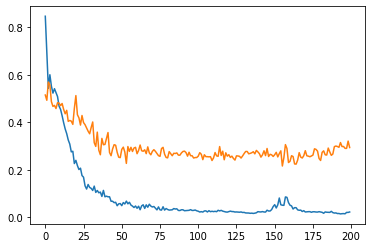

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')

0.40577746915741164


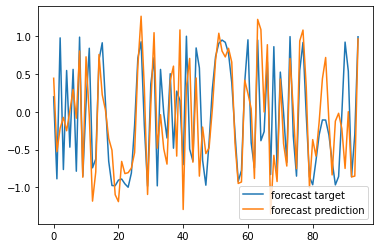

In [ ]:
# predictions for one point
validation_target = Y[-N // 2:]
validation_predictions = []
start = len(X) // 2

for i in range(start, start + len(validation_target)):
    p = model.predict(X[i].reshape(1, -1, 1))[0, 0]
    validation_predictions.append(p)
    
print(mean_absolute_error(validation_target, validation_predictions))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

In [ ]:
def predict(model, x_train, start=0, n_features=1, len_pred=20):
    test_predictions = []
    current_batch = x_train[start]

    for i in range(len_pred):
        current_pred = model.predict(current_batch.reshape((1, -1, n_features)))[0,0]
        test_predictions.append(current_pred)
        current_batch = np.roll(current_batch, -1)
        current_batch[-1] = current_pred
    return test_predictions

0.8787616452124082


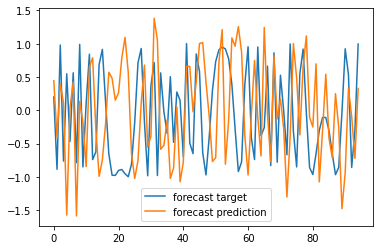

In [ ]:
validation_target = Y[-N // 2 :]
validation_predictions = predict(model, X, N // 2, 1, len(validation_target))
print(mean_absolute_error(validation_target, validation_predictions))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

## 1.3 Long Distance Problem

In [ ]:
T, D, X, Y = 30, 1, [], []

def get_label(x, i1, i2, i3):
    if x[i1] < 0 and x[i2] < 0 and x[i3] < 0:
        return 1
    if x[i1] < 0 and x[i2] > 0 and x[i3] > 0:
        return 1
    if x[i1] > 0 and x[i2] < 0 and x[i3] > 0:
        return 1
    if x[i1] > 0 and x[i2] > 0 and x[i3] < 0:
        return 1
    return 0

for t in range(5000):
    x = np.random.randn(T)
    X.append(x)
    # y = get_label(x, -1, -2, -3) # short distance, predicting based on last 3 values
    y = get_label(x, 0, 1, 2) # long distance
    Y.append(y)

X = np.array(X)
Y = np.array(Y)
N = len(X)

In [ ]:
# RNN fail to perform if T is very long
inputs = np.expand_dims(X, -1)
i = Input(shape=(T, D))

# simpler method only for short term memory, output one final hidden state
# x = SimpleRNN(5)(i)
# x = LSTM(5)(i)
# x = GRU(5)(i)

# return all hidden state (M x T), then do max pooling
x = LSTM(5, return_sequences=True)(i) 
x = GlobalMaxPool1D()(x)

x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
# model.compile(loss='rmsprop', optimizer=SGD(lr=0.1, momentum=0.9), metrics=['accuracy'])

# train the RNN
r = model.fit(inputs, Y, epochs=100, validation_split=0.5)

Epoch 1/100
79/79 [==============================] - 2s 11ms/step - loss: 0.6945 - accuracy: 0.5106 - val_loss: 0.6933 - val_accuracy: 0.4940
Epoch 2/100
79/79 [==============================] - 1s 7ms/step - loss: 0.6939 - accuracy: 0.4904 - val_loss: 0.6952 - val_accuracy: 0.4872
Epoch 3/100
79/79 [==============================] - 1s 6ms/step - loss: 0.6916 - accuracy: 0.5164 - val_loss: 0.6931 - val_accuracy: 0.5132
Epoch 4/100
79/79 [==============================] - 1s 7ms/step - loss: 0.6898 - accuracy: 0.5475 - val_loss: 0.6906 - val_accuracy: 0.5192
Epoch 5/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6883 - accuracy: 0.5262 - val_loss: 0.6937 - val_accuracy: 0.5128
Epoch 6/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6941 - accuracy: 0.5073 - val_loss: 0.6934 - val_accuracy: 0.5048
Epoch 7/100
79/79 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.5130 - val_loss: 0.6937 - val_accuracy: 0.4788
Epoch 8/100


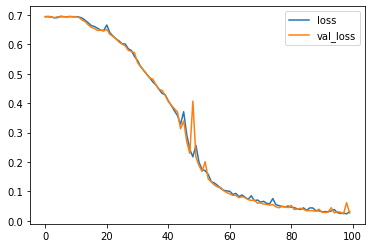

In [ ]:
# Plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

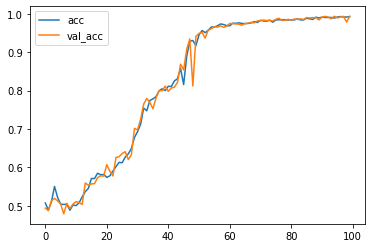

In [ ]:
# Plot the accuracy too
plt.plot(r.history['accuracy'], label='acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()

# 2. Alcohol Sales

In [ ]:
df = pd.read_csv(
    'https://raw.githubusercontent.com/gupta24789/Machine-Learning-Datasets/master/Alcohol_Sales.csv',
    index_col='DATE',
    parse_dates=True)
df.index.freq = 'MS'
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


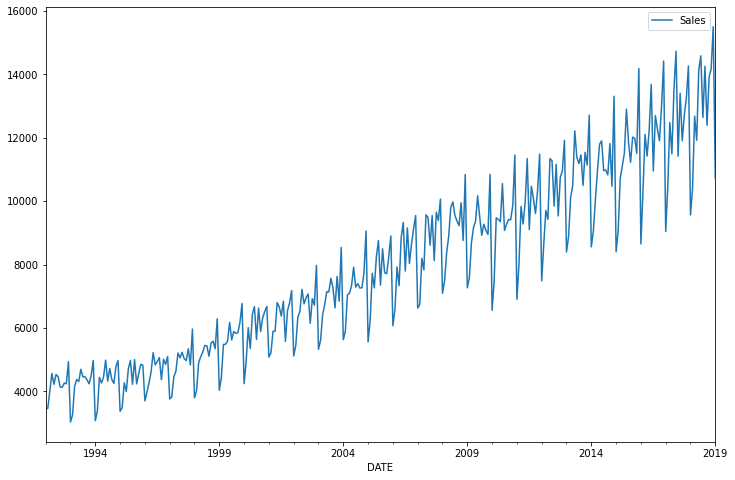

In [ ]:
df.columns = ['Sales']
df.plot(figsize=(12,8))

In [ ]:
train, test = df.iloc[:313], df.iloc[313:]

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(train)
scaled_test = scaler.transform(test)

In [ ]:
# define generator
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)
X, y = generator[0]

print(f'Given the Array: \n {X.flatten()}')
print(f'Predict this y: \n {y}')

Given the Array: 
[0.03658432 0.03649885 0.08299855 0.13103684 0.1017181  0.12804513
 0.12266006 0.09453799 0.09359774 0.10496624 0.10334217 0.16283443]
Predict this y: 
 [[0.]]


In [ ]:
# creating model
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100)               40800     
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# fit model
h = model.fit_generator(generator, epochs=20)

Epoch 1/20
301/301 [==============================] - 6s 18ms/step - loss: 0.0589
Epoch 2/20
301/301 [==============================] - 5s 18ms/step - loss: 0.0084
Epoch 3/20
301/301 [==============================] - 5s 18ms/step - loss: 0.0098
Epoch 4/20
301/301 [==============================] - 5s 18ms/step - loss: 0.0077
Epoch 5/20
301/301 [==============================] - 5s 18ms/step - loss: 0.0061
Epoch 6/20
301/301 [==============================] - 5s 18ms/step - loss: 0.0043
Epoch 7/20
301/301 [==============================] - 6s 18ms/step - loss: 0.0036
Epoch 8/20
301/301 [==============================] - 5s 18ms/step - loss: 0.0032
Epoch 9/20
301/301 [==============================] - 5s 18ms/step - loss: 0.0026
Epoch 10/20
301/301 [==============================] - 5s 18ms/step - loss: 0.0022
Epoch 11/20
301/301 [==============================] - 6s 18ms/step - loss: 0.0022
Epoch 12/20
301/301 [==============================] - 5s 18ms/step - loss: 0.0019
Epoch 13/20
3

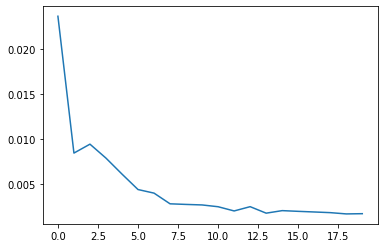

In [ ]:
loss_per_epoch = h.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [ ]:
# evaluation
first_eval_batch = scaled_train[-12:]
first_eval_batch = first_eval_batch.reshape((1, n_input, n_features))
model.predict(first_eval_batch)
# scaled_test[0]

array([[0.6614238]], dtype=float32)

In [ ]:
def predict(model, x_train, start=0, n_features=1, len_pred=20):
    test_predictions = []
    current_batch = x_train[-start:]

    for i in range(len_pred):
        current_pred = model.predict(current_batch.reshape((1, -1, n_features)))[0]
        test_predictions.append(current_pred)
        current_batch = np.roll(current_batch, -1)
        current_batch[-1] = current_pred
    return test_predictions

In [ ]:
pred = predict(model, scaled_train, start=n_input, n_features=1, len_pred=len(test))
true_predictions = scaler.inverse_transform(pred)
test['Prediction'] = true_predictions
test.head()

,Sales,Prediction
DATE,,
2018-02-01,10415,10768.997064
2018-03-01,12683,12152.018344
2018-04-01,11919,11676.871567
2018-05-01,14138,13430.415915
2018-06-01,14583,14288.355710


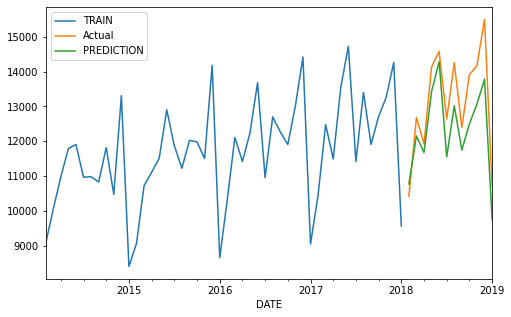

In [ ]:
train['Sales'].iloc[-48:].plot(legend=True, label='TRAIN')
test['Sales'].plot(legend=True, label='Actual', figsize=(8, 5))
test['Prediction'].plot(legend=True, label='PREDICTION');

# 3. Google Stock Price

In [ ]:
dataset_train = pd.read_csv(
    'https://raw.githubusercontent.com/kevincwu0/rnn-google-stock-prediction/master/Google_Stock_Price_Train.csv', 
    usecols=['Date', 'Open']
)
dataset_test = pd.read_csv(
    'https://raw.githubusercontent.com/Parasgr7/Google-Stock-Price-Prediction/master/Google_Stock_Price_Test.csv'
)
real_stock_price = dataset_test.iloc[:, 1:2].values
dataset_total = pd.concat((dataset_train[['Open']], dataset_test[['Open']]), axis = 0)
dataset_train.head()

,Date,Open
0,1/3/2012,325.25
1,1/4/2012,331.27
2,1/5/2012,329.83
3,1/6/2012,328.34
4,1/9/2012,322.04


In [ ]:
training_set = dataset_train[['Open']].values
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
# look back to 60 timesteps
def create_timesteps(train_set, steps=12):
    X, y = [], []
    for i in range(steps, train_set.shape[0]):
        X.append(train_set[i-steps : i, :])
        y.append(train_set[i, :])
    X, y = np.array(X), np.array(y)
    return X,y

X_train, y_train = create_timesteps(training_set_scaled, 60)

In [ ]:
regressor = Sequential()
input_dim = (X_train.shape[1], X_train.shape[-1])
regressor.add(LSTM(units = 50, return_sequences = True, input_shape = input_dim))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50, return_sequences = True))
regressor.add(Dropout(0.2))
regressor.add(LSTM(units = 50))
regressor.add(Dropout(0.2))
regressor.add(Dense(units = 1))

# rmsprop is another good optimizer
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [ ]:
r = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100
38/38 [==============================] - 5s 14ms/step - loss: 0.0946
Epoch 2/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0060
Epoch 3/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0049
Epoch 4/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0047
Epoch 5/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0044
Epoch 6/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0054
Epoch 7/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0053
Epoch 8/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0045
Epoch 9/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0044
Epoch 10/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0039
Epoch 11/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0042
Epoch 12/100
38/38 [==============================] - 0s 12ms/step - loss: 0.0038
Epoch 13/100
38/38 [=====

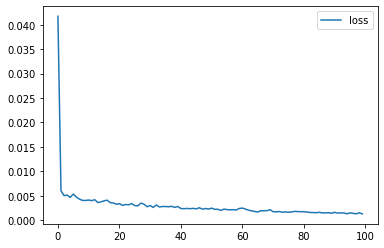

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.legend()

In [ ]:
# use past 60 points to predict 1 point
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = sc.transform(inputs)

X_test = []
for i in range(60, 80):
    X_test.append(inputs[i-60:i, :])

X_test = np.array(X_test)
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

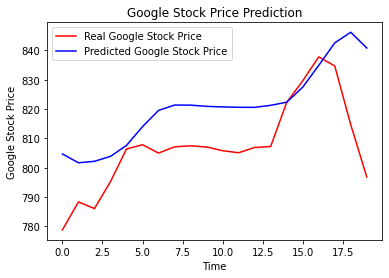

In [ ]:
plt.plot(real_stock_price, color = 'red', label = 'Real Google Stock Price')
plt.plot(predicted_stock_price, color = 'blue', label = 'Predicted Google Stock Price')
plt.title('Google Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.legend()
plt.show()

In [ ]:
# use past 60 points to predict 20 points
def predict(model, x_train, n_features=1, steps=10, len_pred=20):
    test_predictions = []
    first_eval_batch = x_train[-steps:]
    current_batch = first_eval_batch.reshape((1, steps, n_features))
    
    for i in range(len_pred):
        current_pred = model.predict(current_batch)[0]
        test_predictions.append(current_pred) 
        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:, 1:, :], [[current_pred]], axis=1)
    true_predictions = sc.inverse_transform(test_predictions)
    return true_predictions

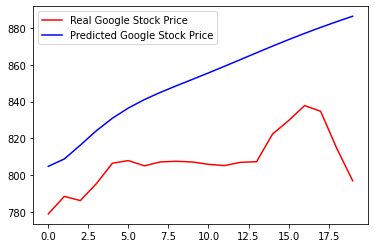

In [ ]:
pred = predict(regressor, training_set_scaled, n_features=1, steps=60, len_pred=len(dataset_test))

result = pd.DataFrame(data = {'Actual' : real_stock_price.flatten(),
                              'Predicted' : [x[0] for x in pred]})

plt.plot(result['Actual'], color = 'red', label = 'Real Google Stock Price')
plt.plot(result['Predicted'], color = 'blue', label = 'Predicted Google Stock Price')
plt.legend()

# 4. Stock Return

## 4.1 Predicting Close Price

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [ ]:
series = df['close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

In [ ]:
# Data Pre-Process
T, D, X, Y = 10, 1, [], []

for t in range(len(series) - T):
    x = series[t : t + T]
    X.append(x)
    y = series[t + T]
    Y.append(y)

# the data should be N x T x D
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X:", X.shape, "\tY:", Y.shape)

X: (1249, 10, 1) 	Y: (1249,)


In [ ]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(loss='mse', optimizer=Adam(lr=0.05))

# train the RNN
r = model.fit(X[:-N // 2], Y[:-N // 2], epochs=50, validation_data=(X[-N // 2:], Y[-N // 2:]))

Epoch 1/50
20/20 [==============================] - 2s 24ms/step - loss: 1.1099 - val_loss: 0.7466
Epoch 2/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0950 - val_loss: 0.2284
Epoch 3/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0149 - val_loss: 0.0448
Epoch 4/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0069 - val_loss: 0.0323
Epoch 5/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0059 - val_loss: 0.0328
Epoch 6/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0056 - val_loss: 0.0289
Epoch 7/50
20/20 [==============================] - 0s 7ms/step - loss: 0.0051 - val_loss: 0.0306
Epoch 8/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0310
Epoch 9/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0066 - val_loss: 0.0356
Epoch 10/50
20/20 [==============================] - 0s 6ms/step - loss: 0.0058 - val_loss: 0.0257
Epoch 11/50
20/20 

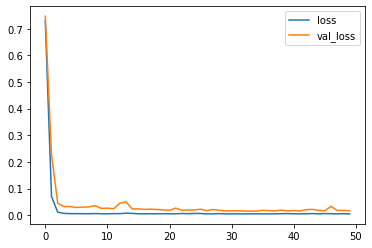

In [ ]:
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()

In [ ]:
def predict(model, x_train, start=0, n_features=1, len_pred=20):
    test_predictions = []
    current_batch = x_train[start]

    for i in range(len_pred):
        current_pred = model.predict(current_batch.reshape((1, -1, n_features)))[0,0]
        test_predictions.append(current_pred)
        current_batch = np.roll(current_batch, -1)
        current_batch[-1] = current_pred
    return test_predictions

0.31318637883425315


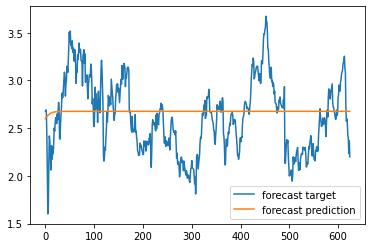

In [ ]:
validation_target = Y[-N // 2 :]
validation_predictions = predict(model, X, N // 2, 1, len(validation_target))
print(mean_absolute_error(validation_target, validation_predictions))
plt.plot(validation_target, label='forecast target')
plt.plot(validation_predictions, label='forecast prediction')
plt.legend();

## 4.2 Classification

In [ ]:
df['PrevClose'] = df['close'].shift(1)
df['Return'] = (df['close'] - df['PrevClose']) / df['PrevClose']
df.head()

,date,open,high,low,close,volume,Name,PrevClose,Return
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX,NaN,NaN
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX,28.185,-0.004080
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX,28.070,0.002138
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX,28.130,-0.007643
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX,27.915,-0.005015


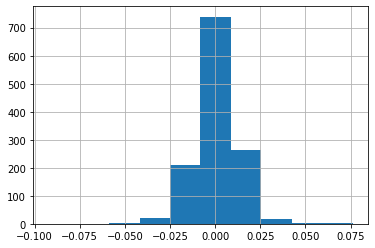

In [ ]:
df['Return'].hist()

In [ ]:
inputs = df[['open', 'high', 'low', 'close', 'volume']].values
targets = df['Return'].values

In [ ]:
# Data Pre-Process
T, D, X, Y = 10, inputs.shape[1], [], []
N = len(inputs) - T

# normalize the inputs
scaler = StandardScaler()
scaler.fit(inputs)
inputs = scaler.transform(inputs)

In [ ]:
for t in range(len(inputs) - T):
    x = inputs[t : t + T]
    X.append(x)
    y = (targets[t + T] > 0) * 1
    Y.append(y)

# the data should be N x T x D
X = np.array(X).reshape(-1, T, D)
Y = np.array(Y)
print("X:", X.shape, "\tY:", Y.shape)

X: (1249, 10, 5) 	Y: (1249,)


In [ ]:
i = Input(shape=(T, D))
x = LSTM(50)(i)
x = Dense(1, activation='sigmoid')(x)
model = Model(i, x)
model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])

N = len(inputs) * 2 // 3
# train the RNN
r = model.fit(X[: N], Y[: N], epochs=200, batch_size=32, validation_data=(X[-N:], Y[-N:]))

Epoch 1/200
27/27 [==============================] - 2s 21ms/step - loss: 0.7204 - accuracy: 0.4735 - val_loss: 0.7169 - val_accuracy: 0.5197
Epoch 2/200
27/27 [==============================] - 0s 7ms/step - loss: 0.6973 - accuracy: 0.5569 - val_loss: 0.7099 - val_accuracy: 0.4982
Epoch 3/200
27/27 [==============================] - 0s 6ms/step - loss: 0.6929 - accuracy: 0.5068 - val_loss: 0.6902 - val_accuracy: 0.5280
Epoch 4/200
27/27 [==============================] - 0s 7ms/step - loss: 0.6914 - accuracy: 0.5268 - val_loss: 0.6917 - val_accuracy: 0.5209
Epoch 5/200
27/27 [==============================] - 0s 6ms/step - loss: 0.6906 - accuracy: 0.5117 - val_loss: 0.6885 - val_accuracy: 0.5471
Epoch 6/200
27/27 [==============================] - 0s 6ms/step - loss: 0.6918 - accuracy: 0.5237 - val_loss: 0.6897 - val_accuracy: 0.5185
Epoch 7/200
27/27 [==============================] - 0s 6ms/step - loss: 0.6876 - accuracy: 0.5507 - val_loss: 0.6899 - val_accuracy: 0.5316
Epoch 8/200


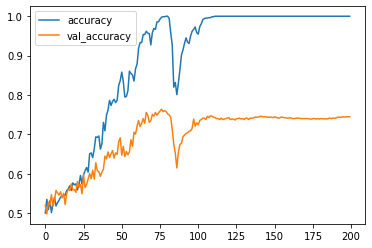

In [ ]:
# 0.5 accuracy = random guess
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()